In [1]:
import gym_electric_motor as gem

basic_env = gem.make("PMSMCont-v1")  # pass a motor environment ID 
basic_env

D:\Anaconda\envs\work\lib\site-packages\gym-0.17.3-py3.7.egg\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
supply = 'RCVoltageSupply'
supply_parameter=dict(R=10, C=4e-3)  # Note, R and C values here are not realistic.

In [3]:
import numpy as np

motor_env_id = "PMSMCont-v1"
tau = 1e-5    # The duration of each sampling step

# motor type: Brusa HSM16.17.12-C01
motor_parameter = dict(p=3,  # [p] = 1, nb of pole pairs
                       r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
                       l_d=0.37e-3,  # [l_d] = H, d-axis inductance
                       l_q=1.2e-3,  # [l_q] = H, q-axis inductance
                       psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
                       )  

nominal_values=dict(omega=4000*2*np.pi/60,  # angular velocity in rpm
                    i=230,                  # motor current in amps
                    u=350                   # nominal voltage in volts
                    )
# limit values are taken exemplarily as 1.3 times the nominal values
limit_values = {key: 1.5 * nomin for key, nomin in nominal_values.items()}


In [4]:
motor_initializer={'random_init': 'uniform', 'interval': [[-230, 230], [-230, 230], [-np.pi, np.pi]]}  

In [5]:
motor_initializer

{'random_init': 'uniform',
 'interval': [[-230, 230],
  [-230, 230],
  [-3.141592653589793, 3.141592653589793]]}

In [6]:
from gym_electric_motor.physical_systems import ConstantSpeedLoad

load = 'ConstSpeedLoad'
load_initializer={'random_init': 'uniform', 'interval':[100,200] }   


In [7]:

gamma = 0.99  #Discount factor for the reward punishment. Should equal agents' discount factor gamma.

def monitor_sqd_currents(state, observed_states, k, physical_system):
    """
    monitor for squared currents:

    i_sd**2 + i_sq**2 < nominal_limit
    """
    I_SD_IDX = physical_system.state_names.index('i_sd') # access motor state i_sd
    I_SQ_IDX = physical_system.state_names.index('i_sq') # access motor state i_sq
    sqd_currents = state[I_SD_IDX] ** 2 + state[I_SQ_IDX] ** 2
    return sqd_currents > 1  

In [8]:
from gym_electric_motor.reference_generators import \
    MultipleReferenceGenerator,\
    WienerProcessReferenceGenerator

q_generator = WienerProcessReferenceGenerator(reference_state='i_sq') # sub-reference generator for i_sq
d_generator = WienerProcessReferenceGenerator(reference_state='i_sd') # sub-reference generator for i_sd
rg = MultipleReferenceGenerator([q_generator, d_generator])           # combine the sub-reference generators

In [9]:
from gym_electric_motor.visualization import MotorDashboard

visualization = MotorDashboard(plots=['i_sq', 'i_sd', 'reward']) # plots the states i_sd and i_sq and reward.

In [10]:
from gym_electric_motor.core import Callback
from pathlib import Path

class RewardLogger(Callback):
    """Logs the reward accumulated in each episode"""
    def __init__(self):
        self._step_rewards = []
        self._mean_episode_rewards = []
        self.fpath = Path.cwd() /"rl_frameworks" / "saved_agents"
        self.fpath.mkdir(parents=True, exist_ok=True)
        
    def on_step_end(self):
        """Stores the received reward at each step"""
        self._step_rewards.append(self._env._reward)
    
    def on_reset_begin(self):
        """Stores the mean reward received in every episode"""
        self._mean_episode_rewards.append(np.mean(self._step_rewards))
        self._step_rewards = []
        
    def on_close(self):
        """Writes the mean episode reward of the experiment to a file."""
        np.save(self.fpath / "EpisodeRewards.npy", np.array(self._mean_episode_rewards))
        
my_callback = [RewardLogger()]  # instantiate the callback object 

In [11]:
# define a PMSM with discrete action space
env = gem.make(  
    motor_env_id,
    # visualize the results
    visualization=visualization,
    # parameterize the PMSM and update limitations
    motor_parameter=motor_parameter,
    limit_values=limit_values, nominal_values=nominal_values,
    # define the random initialisation for load and motor
    load=load,
    load_initializer=load_initializer,
    motor_initializer=motor_initializer,
    reward_function=gem.reward_functions.WeightedSumOfErrors(  # The function that computes the reward
                observed_states=['i_sq', 'i_sd'],              # Names of the observed states
                reward_weights={'i_sq': 10, 'i_sd': 10},       # Reward power for each of the systems states.
                constraint_monitor=monitor_sqd_currents,        # ConstraintMonitor for monitoring
                                                               # states regarding defined constraints
                gamma=gamma,    # Discount factor for the reward punishment. Should equal agent's 
                                # discount factor gamma.
                reward_power=1), # Reward power for each of the systems states
    tau=tau,
    supply = supply,
    supply_parameter=supply_parameter,
    reference_generator=rg,
    ode_solver='euler',
    callbacks = my_callback
)

D:\Anaconda\envs\work\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\envs\work\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


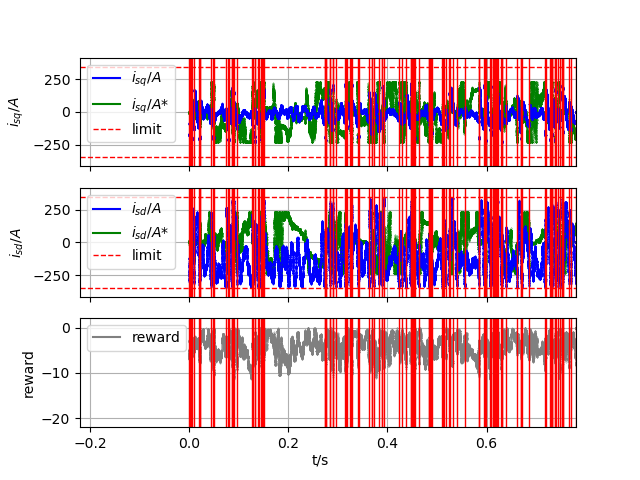

In [12]:
%matplotlib notebook
# simple routine with random actions applied
env.reset()
usd = []
usq = []
isd = []
isq = []
w   = []
for i in range(int(8e4)):    
    env.render()  # visualize environment
    (states, refs), rewards, done, _ = env.step(env.action_space.sample())  # pick random control actions
    usd.append(states[10])
    usq.append(states[11])
    isd.append(states[5])
    isq.append(states[6])
    w.append(states[0])
    if done:
        env.reset()
env.close()

In [14]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


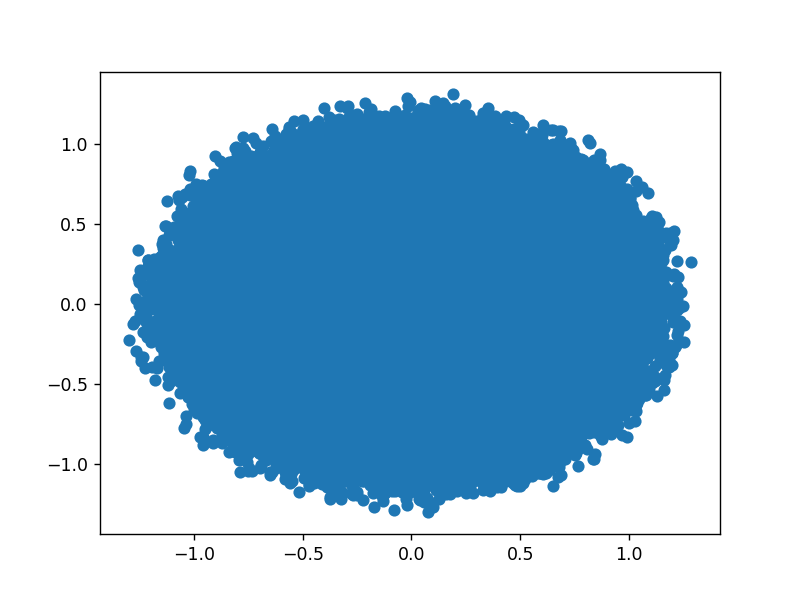

In [16]:
plt.scatter(usd, usq)

<IPython.core.display.Javascript object>


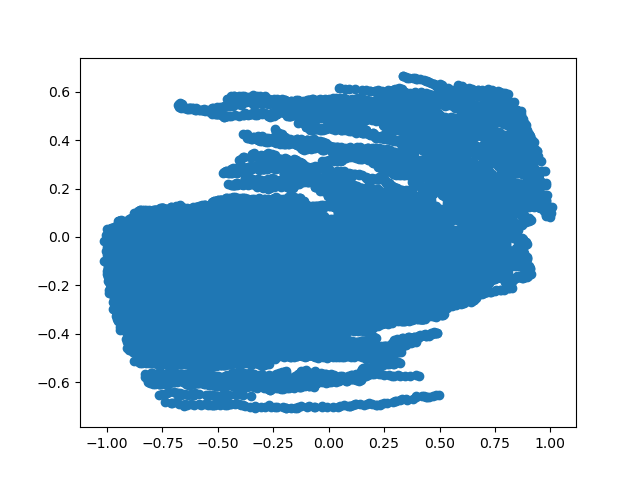

In [14]:
plt.scatter(isd, isq)

<IPython.core.display.Javascript object>


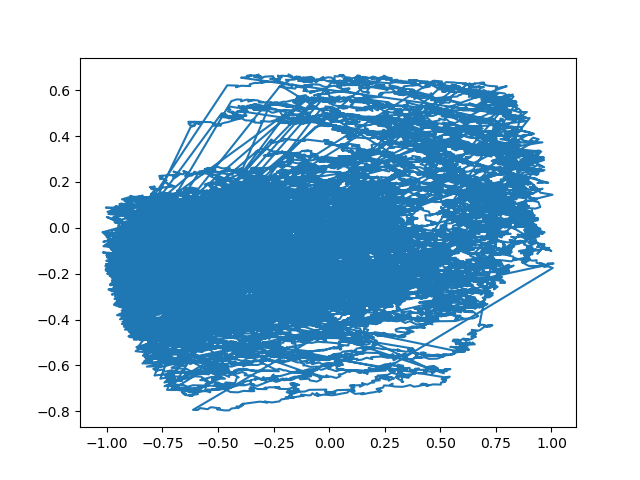

In [44]:
plt.plot(isd, isq)

<IPython.core.display.Javascript object>


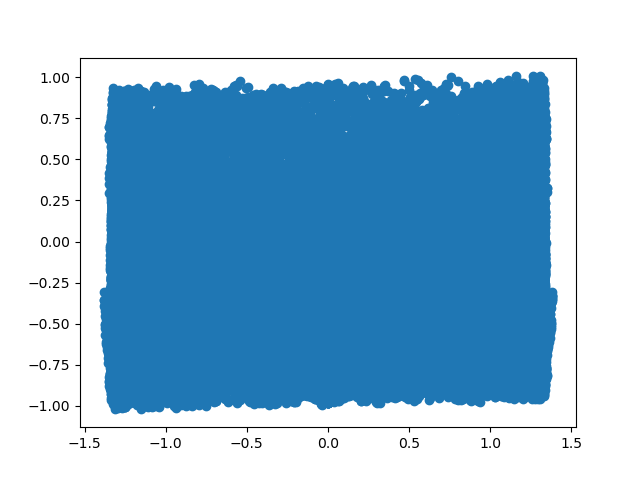

In [45]:
plt.scatter(usd, isd)

<IPython.core.display.Javascript object>


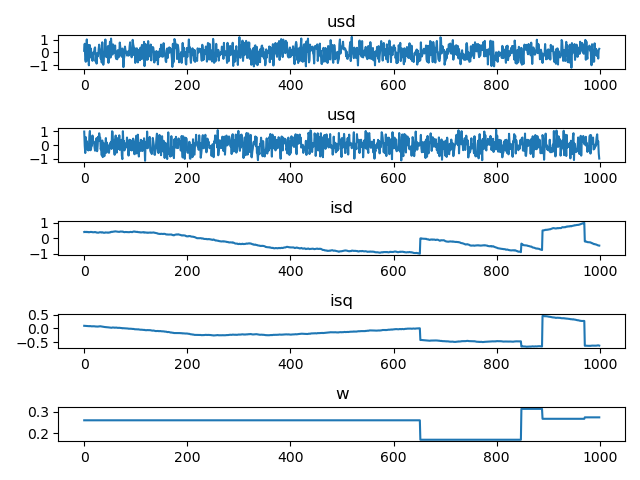

In [15]:
fig, a = plt.subplots(5)
a[0].plot(usd[:1000])
a[0].set_title("usd")
a[1].plot(usq[:1000])
a[1].set_title("usq")
a[2].plot(isd[:1000])
a[2].set_title("isd")
a[3].plot(isq[:1000])
a[3].set_title("isq")
a[4].plot(w[:1000])
a[4].set_title("w")
plt.tight_layout()

<IPython.core.display.Javascript object>


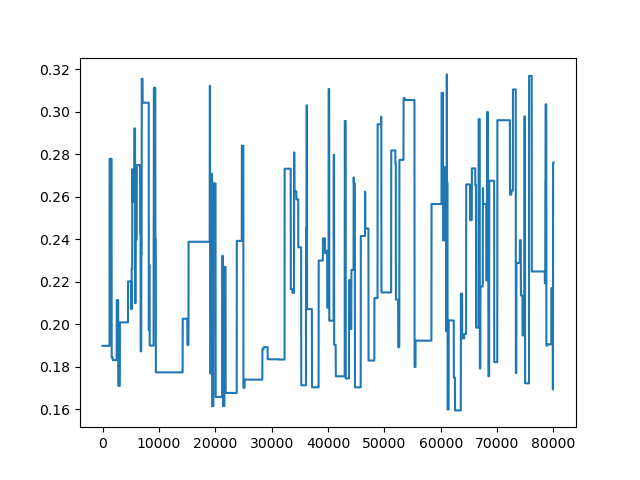

In [47]:
plt.plot(w)

<IPython.core.display.Javascript object>


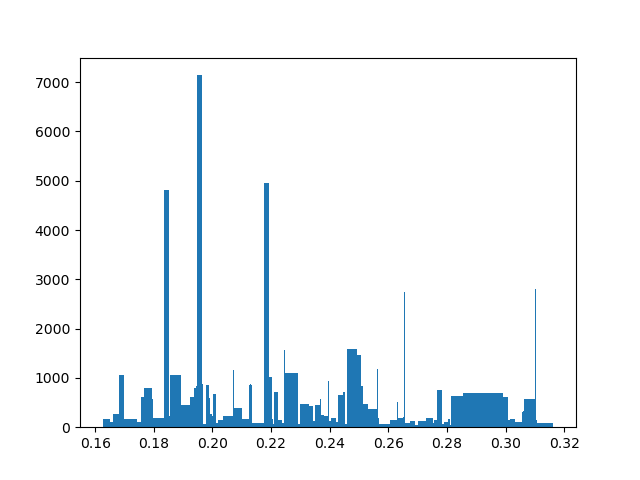

(array([ 168.,  103., 6109.,  273., 1052., 1261.,  165.,  165.,  114.,
         603.,  786.,  582.,  177., 4808.,  218., 1055.,  456.,  607.,
         795.,  842., 7140.,  877.,   63., 3830.,  856., 1155.,  585.,
         273.,  235.,  259.,  677.,   81.,  138.,  236., 1162.,  395.,
         167.,  173.,  846.,  883.,  865.,  843.,   80., 4959., 1020.,
         165.,   64.,  715.,  153.,   77., 1565.,  841., 1095.,   58.,
         479.,   71.,  427.,  122.,  113.,  447.,  141.,  579.,  249.,
         221.,  927.,  123.,  194.,  105.,  645.,  704.,   67., 1596.,
        1474.,  113.,  828.,  462.,  374., 1177.,  177.,   61.,  147.,
         510.,  184.,  200.,   69., 2742.,   94.,  116.,   35.,  130.,
         185.,  196.,   77.,  154.,  764.,   58.,  105.,  157.,   53.,
         112.,  629.,  698.,  605.,  139.,  170.,  739.,  110.,  300.,
         335.,  566., 2808.,  152.,  220.,   93.,   90., 1512.]),
 array([0.16249133, 0.16489186, 0.16589553, 0.16607803, 0.16818798,
        0.1699

In [16]:
fig, ax = plt.subplots() 
ax.hist(w, bins = np.unique(w)) 

In [13]:
usd = np.array(usd)
usq = np.array(usq)
isd = np.array(isd)
isq = np.array(isq)
w = np.array(w)

In [17]:
np.unique(w)

array([0.15934706, 0.16038546, 0.16366598, 0.16371894, 0.16487469,
       0.16492733, 0.16497836, 0.16747064, 0.16797387, 0.16819035,
       0.16995394, 0.1728676 , 0.17328164, 0.17393044, 0.17820314,
       0.17955149, 0.18031156, 0.18335353, 0.18530716, 0.18613721,
       0.18662513, 0.18778728, 0.18844939, 0.18877009, 0.19019293,
       0.19472787, 0.1947483 , 0.19771352, 0.19899149, 0.19961996,
       0.20058896, 0.20061273, 0.20168079, 0.20168408, 0.20364521,
       0.20377909, 0.20673614, 0.20971229, 0.21176361, 0.21303654,
       0.21416493, 0.21497911, 0.21513559, 0.22017192, 0.22047564,
       0.22420384, 0.2246635 , 0.2256347 , 0.22686395, 0.22836952,
       0.22874248, 0.22952507, 0.22974442, 0.231483  , 0.23298139,
       0.23306548, 0.23368362, 0.23563156, 0.23617742, 0.2371759 ,
       0.23811647, 0.23944337, 0.23961814, 0.24133968, 0.24150094,
       0.24172215, 0.24202325, 0.24436791, 0.24482565, 0.2460179 ,
       0.24830891, 0.25035909, 0.25135911, 0.25443153, 0.25744

In [21]:
len(w)

80000

In [22]:
k = np.unique(w)

In [23]:
len(k)

122

In [23]:
ud = np.expand_dims(usd, 1)

In [24]:
uq = np.expand_dims(usq, 1)
id_ = np.expand_dims(isd, 1)
iq_ = np.expand_dims(isq, 1)

In [32]:
w = np.expand_dims(w, 1)

In [33]:
mat = np.concatenate([ud, uq, id_, iq_, w], axis = 1)    

In [34]:
np.shape(mat)

(80000, 5)

In [22]:
ud_iid = []
ud_ood = []
uq_iid = []
uq_ood = []
id_iid = []
id_ood = []
iq_iid = []
iq_ood = []
w_iid = []
w_ood = []

for i in range(0, np.shape(usd)[0]):
    if((ud[i][0] > 0 and uq[i][0] < 0) or (ud[i][0] < 0 and uq[i][0] > 0)):
        ud_ood.append(ud[i][0])
        uq_ood.append(uq[i][0])
        id_ood.append(id_[i][0])
        iq_ood.append(iq_[i][0])
        w_ood.append(w[i][0])
    else:
        ud_iid.append(ud[i][0])
        uq_iid.append(uq[i][0])
        id_iid.append(id_[i][0])
        iq_iid.append(iq_[i][0])
        w_iid.append(w[i][0])

In [23]:
ud = np.expand_dims(ud_iid, 1)
uq = np.expand_dims(uq_iid, 1)
id_ = np.expand_dims(id_iid, 1)
iq_ = np.expand_dims(iq_iid, 1)
w = np.expand_dims(w_iid, 1)

mat = np.concatenate([ud, uq, id_, iq_, w], axis = 1)    
with open("PMSM_Contv2_iid.csv", "a") as f:
    np.savetxt(f, mat, delimiter=',')

In [24]:
ud = np.expand_dims(ud_ood, 1)
uq = np.expand_dims(uq_ood, 1)
id_ = np.expand_dims(id_ood, 1)
iq_ = np.expand_dims(iq_ood, 1)
w = np.expand_dims(w_ood, 1)

mat = np.concatenate([ud, uq, id_, iq_, w], axis = 1)    
with open("PMSM_Contv2_ood.csv", "a") as f:
    np.savetxt(f, mat, delimiter=',')

In [21]:
kk = np.array([1,2])
len(kk)

2

In [17]:
ud = np.expand_dims(ud, 1)
uq = np.expand_dims(uq, 1)
id_ = np.expand_dims(id_, 1)
iq_ = np.expand_dims(iq_, 1)
w = np.expand_dims(w, 1)

mat = np.concatenate([ud, uq, id_, iq_, w], axis = 1)    
with open("PMSM.csv", "a") as f:
    np.savetxt(f, mat, delimiter=',')

ValueError: Expected 1D or 2D array, got 3D array instead

In [35]:
with open("PMSM.csv", "a") as f:
    np.savetxt(f, mat, delimiter=',')